# Round Trip Astrometry Test
The following piece of code performs a test of the internal precision of WCS pixel to sky coordinate conversions. After a few round trips, a surprisingly large error of order a milliarcsecond accumulates. There is an option

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [2]:
from lsst.daf.persistence import Butler
from lsst.afw.geom import Point2D, SpherePoint, makeSkyWcs, makeCdMatrix, degrees, arcseconds

In [3]:
butler = Butler('/home/shared/twinkles/output_data_v2')
subset = butler.subset('calexp', filter='r') # Pick a random visit
calexp = butler.get('calexp', **subset.cache[-1])

In [4]:
#wcs = makeSkyWcs(Point2D(0, 0), SpherePoint(40, 30, degrees), makeCdMatrix(scale=1*arcseconds))
#wcs = calexp.getWcs()
#help(wcs)
#print(dir(wcs))
#t = wcs.getTransform()
#t_inv = t.getInverse()
#print(dir(t_inv))
#print(wcs.getPixelOrigin())
#print(wcs.getSkyOrigin())
#print(wcs.getCdMatrix())
#print(type(wcs))
#print(type(t))
#print(dir(t))

In [5]:
def roundTrip(calexp, pixel_x, pixel_y, n=11, simple_wcs=False):
    if simple_wcs:
        #wcs = makeSkyWcs(Point2D(0, 0), SpherePoint(40, 30, degrees), makeCdMatrix(scale=1*arcseconds))
        wcs = makeSkyWcs(calexp.getWcs().getPixelOrigin(),
                         calexp.getWcs().getSkyOrigin(),
                         calexp.getWcs().getCdMatrix())
        wcs = calexp.getWcs().getTanWcs()
    else:
        wcs = calexp.getWcs()
    n = 11
    pixel_array = [Point2D(pixel_x, pixel_y)]
    sky_array = []
    separation_array = np.empty(n)
    ra_array, dec_array = np.empty(n), np.empty(n)
    for ii in range(0, n):
        sky_array.append(wcs.pixelToSky(pixel_array[-1]))
        pixel_array.append(wcs.skyToPixel(sky_array[-1]))
        separation_array[ii] = sky_array[0].separation(sky_array[-1]).asArcseconds()
        ra_array[ii] = sky_array[ii].getRa().asDegrees()
        dec_array[ii] = sky_array[ii].getDec().asDegrees()
    return separation_array, ra_array, dec_array

In [6]:
separation_array, ra_array, dec_array = roundTrip(calexp, 1000., 1000.)

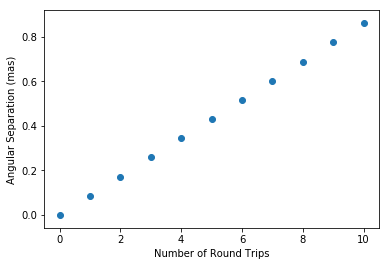

In [7]:
plt.figure()
plt.scatter(np.arange(len(separation_array)), 1000. * separation_array)
plt.xlabel('Number of Round Trips')
plt.ylabel('Angular Separation (mas)')

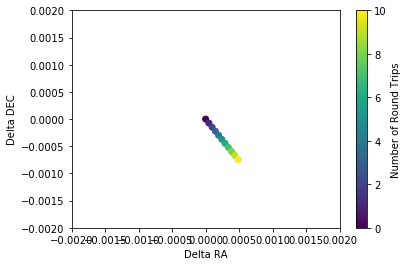

In [8]:
plt.figure()
plt.scatter(3600. * (ra_array - ra_array[0]), 3600. * (dec_array - dec_array[0]), c=np.arange(len(ra_array)))
plt.colorbar().set_label('Number of Round Trips')
plt.xlim(-2.e-3, 2.e-3)
plt.ylim(-2.e-3, 2.e-3)
plt.xlabel('Delta RA')
plt.ylabel('Delta DEC')

In [9]:
n = 10000
pixel_x_array = np.random.uniform(0, calexp.getDimensions()[0], n)
pixel_y_array = np.random.uniform(0, calexp.getDimensions()[1], n)

In [10]:
round_trip_separation_array = np.empty(n)
round_trip_ra_array = np.empty(n)
round_trip_dec_array = np.empty(n)
round_trip_delta_ra_array = np.empty(n)
round_trip_delta_dec_array = np.empty(n)
for ii in range(0, n):
    separation_array, ra_array, dec_array = roundTrip(calexp, pixel_x_array[ii], pixel_y_array[ii]) 
    round_trip_separation_array[ii] = separation_array[1]
    round_trip_ra_array[ii] = ra_array[0]
    round_trip_dec_array[ii] = dec_array[0]
    round_trip_delta_ra_array[ii] = ra_array[1] - ra_array[0]
    round_trip_delta_dec_array[ii] = dec_array[1] - dec_array[0]

Median 1 Round Trip Separation = 5.144e-02 mas


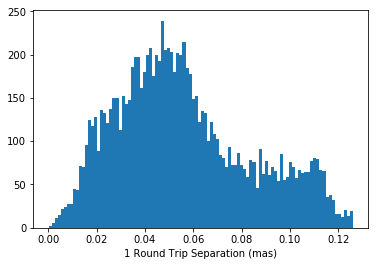

In [11]:
plt.figure()
plt.hist(1000. * round_trip_separation_array, bins=100)
plt.xlabel('1 Round Trip Separation (mas)')
print('Median 1 Round Trip Separation = %.3e mas'%(1000. * np.median(round_trip_separation_array)))

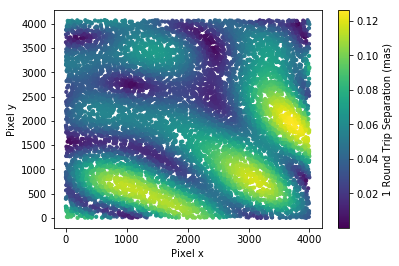

In [12]:
plt.figure()
plt.scatter(pixel_x_array, pixel_y_array, c=1000. * round_trip_separation_array, s=10)
plt.colorbar().set_label('1 Round Trip Separation (mas)')
#colorbar.set_label('')
plt.xlabel('Pixel x')
plt.ylabel('Pixel y')

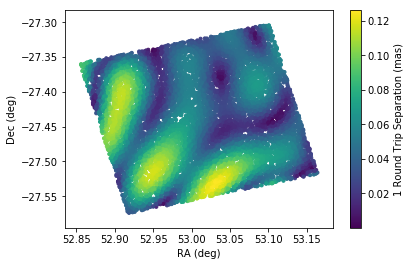

In [13]:
plt.figure()
plt.scatter(round_trip_ra_array, round_trip_dec_array, c=1000. * round_trip_separation_array, s=10)
plt.colorbar().set_label('1 Round Trip Separation (mas)')
#colorbar.set_label('')
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')

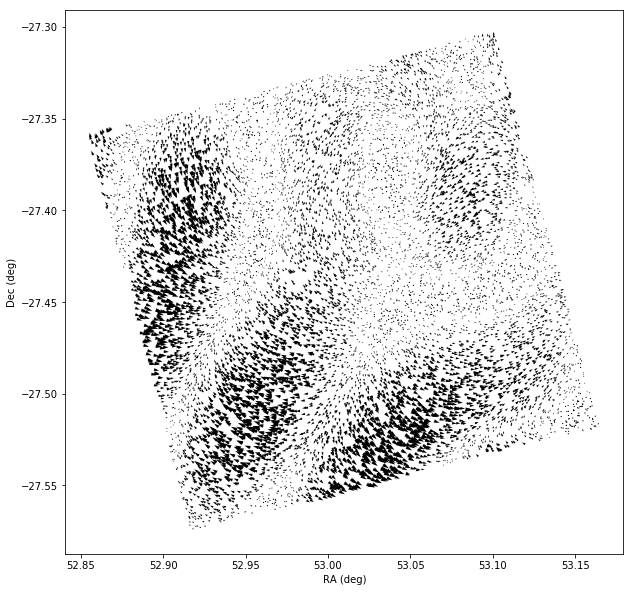

In [14]:
plt.figure(figsize=(10, 10))
#plt.quiver(round_trip_ra_array, round_trip_dec_array, round_trip_delta_ra_array, round_trip_delta_dec_array, round_trip_separation_array)
#plt.colorbar().set_label('1 Round Trip Separation (mas)')
plt.quiver(round_trip_ra_array, round_trip_dec_array, round_trip_delta_ra_array, round_trip_delta_dec_array)
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')

Now as a further test, let's look at the difference between the full wcs and the simplified wcs version which is just the projection (as I understand it). The difference between the two should be revealing the amplitude and pattern of the small-scale distortions.

In [15]:
simple_wcs = makeSkyWcs(calexp.getWcs().getPixelOrigin(),
                        calexp.getWcs().getSkyOrigin(),
                        calexp.getWcs().getCdMatrix())
distortion_separation_array = np.empty(n)
distortion_ra_array = np.empty(n)
distortion_dec_array = np.empty(n)
distortion_delta_ra_array = np.empty(n)
distortion_delta_dec_array = np.empty(n)
for ii in range(0, n):
    sky = calexp.getWcs().pixelToSky(Point2D(pixel_x_array[ii], pixel_y_array[ii]))
    sky_simple = simple_wcs.pixelToSky(Point2D(pixel_x_array[ii], pixel_y_array[ii]))
    distortion_separation_array[ii] = sky.separation(sky_simple).asArcseconds()
    distortion_ra_array[ii] = sky.getRa().asDegrees()
    distortion_dec_array[ii] = sky.getDec().asDegrees()
    distortion_delta_ra_array[ii] = sky.getRa().asDegrees() - sky_simple.getRa().asDegrees()
    distortion_delta_dec_array[ii] = sky.getDec().asDegrees() - sky_simple.getDec().asDegrees()

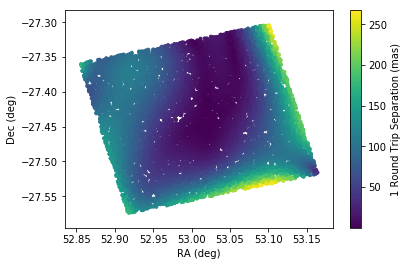

In [16]:
plt.figure()
plt.scatter(distortion_ra_array, distortion_dec_array, c=1000. * distortion_separation_array, s=10)
plt.colorbar().set_label('1 Round Trip Separation (mas)')
#colorbar.set_label('')
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')

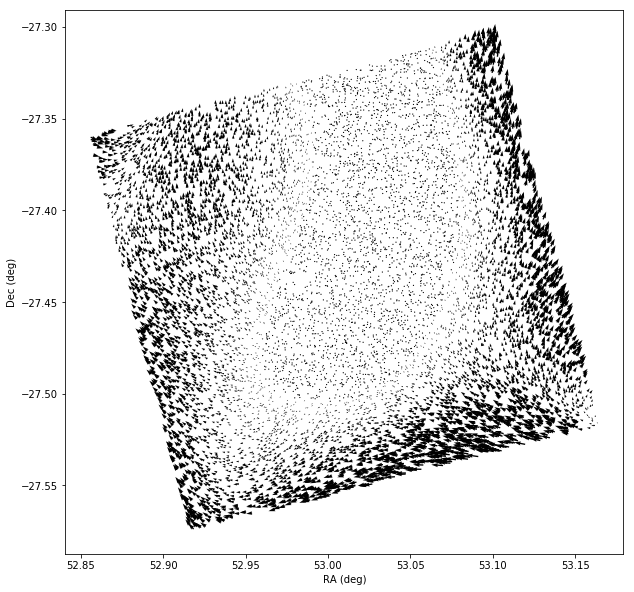

In [17]:
plt.figure(figsize=(10, 10))
#plt.quiver(round_trip_ra_array, round_trip_dec_array, round_trip_delta_ra_array, round_trip_delta_dec_array, round_trip_separation_array)
#plt.colorbar().set_label('1 Round Trip Separation (mas)')
plt.quiver(distortion_ra_array, distortion_dec_array, distortion_delta_ra_array, distortion_delta_dec_array)
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')